In [37]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

This data set is collected from a site called [Personality Cafe](http://personalitycafe.com/) (I stole it from [Kaggle](https://www.kaggle.com/datasnaek/mbti-type)).

It contains people's [Myers-Briggs Personality](https://en.wikipedia.org/wiki/Myers–Briggs_Type_Indicator) types as well as posts they made on the site.

In [2]:
data = pd.read_csv('./mbti_1.csv')

In [4]:
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In the "type" column, above, consists of personality types denoted in four letters. For now we'll just focus on the first column, which is either the letter 'I' for introvert or 'E' for extrovert.

The "posts" column contains the last 50 posts a user made, each seperated by '|||'

## Introverted v Extroverted

In [18]:
def isExtroverted(in_string):
    if in_string[0] == 'I':
        return False
    elif in_string[0] == 'E':
        return True
    else:
        raise Exception('Found neither I nor E: ' + in_string[0]) 


In [31]:
data['extroverted'] = data['type'].map(isExtroverted)

What percent of our data set is introverted versus extroverted?

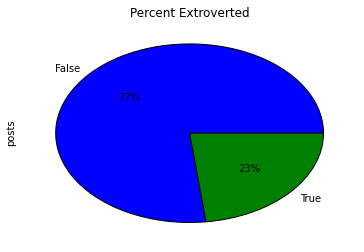

In [55]:
data.groupby('extroverted').count()['posts'].plot.pie(autopct='%1.0f%%')
plt.title("Percent Extroverted")

Only 23% of our users are extroverted--not so shocking for a web forum...

Anyway, we want to see the difference in how introverts and extroverts post. So let's choose an equal sample of 
introverts and extroverts to work with. Since we have only 1999 extroverts, let's grab a sample of ~4000 that's split 50/50 introvert/extrovert.

In [58]:
sample = data[data.extroverted].sample(1999)
sample = sample.append(data[~data.extroverted].sample(1999))

In [60]:
sample.groupby('extroverted').count()

,type,posts
extroverted,,
False,1999,1999
True,1999,1999


## Text Tokens

We're going to analyze users' posts in the simplest way possible--by looking at the words that they use. So the first step is to clean up the data, and create a column that contains the words a user's used without spaces, punctuation, or other artifacts.

In [102]:
from nltk.tokenize import wordpunct_tokenize
import re
from nltk.corpus import stopwords

In [103]:
# These are boring, filler words -- things like 'a', 'the', 'we', etc
stopwords = stopwords.words('english') 

In [67]:
sample = sample.reset_index()

In [104]:
def tokenize(posts):
    
    # Replace |||--which means a new post has started--with a space
    posts = posts.replace('|||', ' ')
    
    # Remove urls (https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python)
    posts = re.sub(r'http\S+', '', posts)
    
    posts = posts.lower() # make everything lowercase
    
    # wordpunct_tokenize splits words by spacse or punctation, and returns an array of words
    posts = wordpunct_tokenize(posts)
    
    # remove the stopwords
    return [x for x in posts if not x in stopwords]

In [105]:
sample['tokens'] = sample['posts'].map(tokenize) # This could take a while...

/Library/Python/2.7/site-packages/ipykernel/__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


## Text Summary

Next we're going to take a look at which words extroverts use more than introverts and vice versa.
We'll do this by calculating the difference in word usage frequency in each group, which we'll define as
__the percent of users who use a word at least once in any of their posts__.

In [126]:
def getFrequencies(df):
    df = df['tokens'].map(set).map(list) # going from a list to a set to a list means we drop duplicates
    df = df.sum() # Concatenates all the tokens. warning: THIS COULD TAKE A LONG TIME
    return pd.Series(df).value_counts() # Value counts tells us how many users used a given word

In [127]:
extro_frequencies = getFrequencies(sample[sample.extroverted])

In [129]:
intro_frequencies = getFrequencies(sample[~sample.extroverted])

In [132]:
extro_frequencies.head(20)

'         1999
.         1998
,         1996
...       1996
like      1985
?         1957
think     1935
people    1924
one       1921
know      1906
:         1888
-         1886
get       1862
would     1856
m         1845
really    1832
(         1823
time      1814
well      1766
much      1732
dtype: int64

As we see above, there are some artifacs here--we don't care about apostraphes or periods. But looking further down the list, we see almost all of the extroverts used the word like, think, and people at least once. That's not alone terribly interesting. What we _really_ want to find are the words that extroverts use often that introverts don't and vice versa! 

Let's start by getting our results back into a dataframe:

In [151]:
frequenices = pd.DataFrame(extro_frequencies, columns=['extrovert_count'])

In [152]:
frequencies = frequenices.join(pd.DataFrame(intro_frequencies, columns=['introvert_count'])).fillna(0)

In [158]:
frequencies = frequencies / 1999 * 100 # Let's look at percentages instead of raw counts

In [160]:
# The most interesting words are the ones where the difference in percentage usage is the highest
frequencies['difference'] = frequencies['extrovert_count'] - frequencies['introvert_count']

In [168]:
# Words used more by introverts than extroverts
frequencies.sort_values('difference').head(25)

,extrovert_count,introvert_count,difference
infp,40.870435,50.825413,-9.954977
infps,14.507254,22.661331,-8.154077
music,27.813907,34.867434,-7.053527
intp,37.118559,43.421711,-6.303152
family,26.763382,32.616308,-5.852926
living,16.258129,22.011006,-5.752876
listening,11.255628,16.808404,-5.552776
school,39.019510,44.572286,-5.552776
human,18.509255,23.811906,-5.302651
books,14.907454,20.110055,-5.202601


In [167]:
# Words used more by extroverts than introverts
frequencies.sort_values('difference').tail(15)

,extrovert_count,introvert_count,difference
awesome,31.065533,23.811906,7.253627
super,21.460730,14.157079,7.303652
!!,22.611306,14.607304,8.004002
;),19.509755,11.255628,8.254127
fun,46.523262,38.069035,8.454227
lol,45.872936,36.268134,9.604802
enfj,31.065533,19.859930,11.205603
estp,27.163582,15.707854,11.455728
ne,31.365683,19.209605,12.156078
guys,47.823912,35.017509,12.806403


Voila! According to data, extroverts are more likely than introverts to use words like: awesome, super, !!, ;), fun, lol--kind of makes sense, right? Where as introverts talk about music, family, listening, quiet, and alone more than extroverts. Plus, we see that both introverts and extroverts list their Myers-Briggs types (that's what those entj, enfp, infp, etc entries are for), which gives us confidence that our analysis is working and that we didn't make a mistake.